# Mark rooftops with u-net - MultiResUnet
https://reader.elsevier.com/reader/sd/pii/S0893608019302503?token=EA6BD81449BC89BBE7E52FCEBFB6BB26638CC60D0DDC7B83555A68588F2231E0FBD14BB12E5667F380B94FE59C341D80&originRegion=eu-west-1&originCreation=20220118124805

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')
%cd gdrive/MyDrive/M_DV_V2022

Mounted at /content/gdrive
/content/gdrive/MyDrive/M_DV_V2022


In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

from keras.models import Sequential, Model
from keras.layers import Input, Dense, Conv2D, Flatten, \
                         UpSampling2D, Conv2DTranspose, MaxPooling2D, \
                         Dropout, Concatenate, BatchNormalization, Activation, \
                         concatenate, DepthwiseConv2D, ReLU, Add, Conv1D, LayerNormalization, \
                         Layer, Flatten, MaxPooling1D, Activation, add
from tensorflow.keras.optimizers import Adam
from keras.layers.advanced_activations import ELU, LeakyReLU

from tensorflow.keras import losses
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.callbacks import LearningRateScheduler
import h5py

from tensorflow.image import resize
import keras.backend as K

### Load data

In [4]:
X_train = np.load("data/u_net_roofs/X_data.npy")
y_train = np.load("data/u_net_roofs/y_data.npy")

X_val = np.load("data/u_net_roofs/X_data_val.npy")
y_val = np.load("data/u_net_roofs/y_data_val.npy")

X_test = np.load("data/u_net_roofs/X_data_test.npy")
y_test = np.load("data/u_net_roofs/y_data_test.npy")


In [13]:
def redesign_y(y):
  n,r1,c1,d = y.shape
  # Adds a new dimension of layer too have two class problem.
  yy = np.append(y, np.zeros((n, r1, c1,d)), axis=3)
  for i in range(int(y.max()-1)):  
    yy = np.append(yy, np.zeros((n, r1, c1,d)), axis=3)
  #yy[yy >= 0.001] = 1
  yy1 = yy.copy()
  yy1[:,:,:,0] = 0 # reset map
  for i in range(n):
    values = yy[i,:,:,0]
    for r in range(r1):
      for c in range(c1):
        value = yy[i,r,c,0]
        yy1[i,r,c,int(value)] = 1

  return yy1

In [14]:
y_train = redesign_y(y_train)
y_val = redesign_y(y_val)
y_test = redesign_y(y_test)

print(y_train.shape)
print(y_val.shape)
print(y_test.shape)

(1000, 128, 128, 2)
(200, 128, 128, 2)
(500, 128, 128, 2)


In [ ]:
X[:,:,:,-1] *= 100 # Set back nDSM to orignal levels

In [ ]:
#X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    yy1, 
                                                    test_size=0.2, 
                                                    random_state=42)

In [ ]:
X_train.shape

(1000, 128, 128, 6)

### Make MultiResUnet

In [5]:
def conv2d_bn(x, filters, num_row, num_col, padding='same', strides=(1, 1), activation='relu', name=None):
    '''
    2D Convolutional layers
    
    Arguments:
        x {keras layer} -- input layer 
        filters {int} -- number of filters
        num_row {int} -- number of rows in filters
        num_col {int} -- number of columns in filters
    
    Keyword Arguments:
        padding {str} -- mode of padding (default: {'same'})
        strides {tuple} -- stride of convolution operation (default: {(1, 1)})
        activation {str} -- activation function (default: {'relu'})
        name {str} -- name of the layer (default: {None})
    
    Returns:
        [keras layer] -- [output layer]
    '''

    x = Conv2D(filters, (num_row, num_col), strides=strides, padding=padding, use_bias=False)(x)
    x = BatchNormalization(axis=3, scale=False)(x)

    if(activation == None):
        return x

    x = Activation(activation, name=name)(x)

    return x


def trans_conv2d_bn(x, filters, num_row, num_col, padding='same', strides=(2, 2), name=None):
    '''
    2D Transposed Convolutional layers
    
    Arguments:
        x {keras layer} -- input layer 
        filters {int} -- number of filters
        num_row {int} -- number of rows in filters
        num_col {int} -- number of columns in filters
    
    Keyword Arguments:
        padding {str} -- mode of padding (default: {'same'})
        strides {tuple} -- stride of convolution operation (default: {(2, 2)})
        name {str} -- name of the layer (default: {None})
    
    Returns:
        [keras layer] -- [output layer]
    '''

    x = Conv2DTranspose(filters, (num_row, num_col), strides=strides, padding=padding)(x)
    x = BatchNormalization(axis=3, scale=False)(x)
    
    return x


def MultiResBlock(U, inp, alpha = 1.67):
    '''
    MultiRes Block
    
    Arguments:
        U {int} -- Number of filters in a corrsponding UNet stage
        inp {keras layer} -- input layer 
    
    Returns:
        [keras layer] -- [output layer]
    '''

    W = alpha * U

    shortcut = inp

    shortcut = conv2d_bn(shortcut, int(W*0.167) + int(W*0.333) +
                         int(W*0.5), 1, 1, activation=None, padding='same')

    conv3x3 = conv2d_bn(inp, int(W*0.167), 3, 3,
                        activation='relu', padding='same')

    conv5x5 = conv2d_bn(conv3x3, int(W*0.333), 3, 3,
                        activation='relu', padding='same')

    conv7x7 = conv2d_bn(conv5x5, int(W*0.5), 3, 3,
                        activation='relu', padding='same')

    out = concatenate([conv3x3, conv5x5, conv7x7], axis=3)
    out = BatchNormalization(axis=3)(out)

    out = add([shortcut, out])
    out = Activation('relu')(out)
    out = BatchNormalization(axis=3)(out)

    return out


def ResPath(filters, length, inp):
    '''
    ResPath
    
    Arguments:
        filters {int} -- [description]
        length {int} -- length of ResPath
        inp {keras layer} -- input layer 
    
    Returns:
        [keras layer] -- [output layer]
    '''


    shortcut = inp
    shortcut = conv2d_bn(shortcut, filters, 1, 1,
                         activation=None, padding='same')

    out = conv2d_bn(inp, filters, 3, 3, activation='relu', padding='same')

    out = add([shortcut, out])
    out = Activation('relu')(out)
    out = BatchNormalization(axis=3)(out)

    for i in range(length-1):

        shortcut = out
        shortcut = conv2d_bn(shortcut, filters, 1, 1,
                             activation=None, padding='same')

        out = conv2d_bn(out, filters, 3, 3, activation='relu', padding='same')

        out = add([shortcut, out])
        out = Activation('relu')(out)
        out = BatchNormalization(axis=3)(out)

    return out

In [11]:
def MultiResUnet(inputs, n_classes=1):
    '''
    MultiResUNet
    
    Arguments:
        height {int} -- height of image 
        width {int} -- width of image 
        n_channels {int} -- number of channels in image
    
    Returns:
        [keras model] -- MultiResUNet model
    '''


    #inputs = Input((height, width, n_channels))

    mresblock1 = MultiResBlock(32, inputs)
    pool1 = MaxPooling2D(pool_size=(2, 2))(mresblock1)
    mresblock1 = ResPath(32, 4, mresblock1)

    mresblock2 = MultiResBlock(32*2, pool1)
    pool2 = MaxPooling2D(pool_size=(2, 2))(mresblock2)
    mresblock2 = ResPath(32*2, 3, mresblock2)

    mresblock3 = MultiResBlock(32*4, pool2)
    pool3 = MaxPooling2D(pool_size=(2, 2))(mresblock3)
    mresblock3 = ResPath(32*4, 2, mresblock3)

    mresblock4 = MultiResBlock(32*8, pool3)
    pool4 = MaxPooling2D(pool_size=(2, 2))(mresblock4)
    mresblock4 = ResPath(32*8, 1, mresblock4)

    mresblock5 = MultiResBlock(32*16, pool4)

    up6 = concatenate([Conv2DTranspose(
        32*8, (2, 2), strides=(2, 2), padding='same')(mresblock5), mresblock4], axis=3)
    mresblock6 = MultiResBlock(32*8, up6)

    up7 = concatenate([Conv2DTranspose(
        32*4, (2, 2), strides=(2, 2), padding='same')(mresblock6), mresblock3], axis=3)
    mresblock7 = MultiResBlock(32*4, up7)

    up8 = concatenate([Conv2DTranspose(
        32*2, (2, 2), strides=(2, 2), padding='same')(mresblock7), mresblock2], axis=3)
    mresblock8 = MultiResBlock(32*2, up8)

    up9 = concatenate([Conv2DTranspose(32, (2, 2), strides=(
        2, 2), padding='same')(mresblock8), mresblock1], axis=3)
    mresblock9 = MultiResBlock(32, up9)

    acti = 'sigmoid'
    if n_classes > 1:
      acti = 'softmax'
    conv10 = conv2d_bn(mresblock9, n_classes, 1, 1, activation=acti)
    
    model = Model(inputs=[inputs], outputs=[conv10])

    return model

In [7]:
smooth = 1

def jacard(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum ( y_true_f * y_pred_f)
    union = K.sum ( y_true_f + y_pred_f - y_true_f * y_pred_f)
    return intersection/union


def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

### Show data - 5 random images

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[912 519 806 934 113]


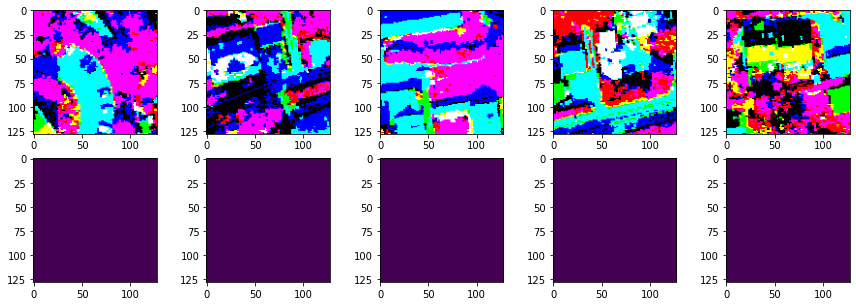

In [8]:
fig, ax = plt.subplots(nrows=2, ncols=5, figsize = (15,5))

indx = np.random.randint(0,high=X_train.shape[0],size=5)
print(indx)
for i in range(5):
    #ax[0,i].imshow(np.dstack((X_train[indx[i]][:,:,76],
    #                          X_train[indx[i]][:,:,46],
    #                          X_train[indx[i]][:,:,21])))
    ax[0,i].imshow(X_train[indx[i]][:,:,0:3])
    ax[1,i].imshow(y_train[indx[i]].argmax(axis=2))
plt.show()

### Set up u net

In [22]:
# Free up RAM in case the model definition cells were run multiple times
K.clear_session()

# Build model
model = None

input_img = Input(shape=(128,128,6))
model = MultiResUnet(input_img, n_classes=2)

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=[dice_coef, jacard, 'accuracy'])

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 6  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_1 (Conv2D)              (None, 128, 128, 8)  432         ['input_1[0][0]']                
                                                                                                  
 batch_normalization_1 (BatchNo  (None, 128, 128, 8)  24         ['conv2d_1[0][0]']               
 rmalization)                                                                                     
                                                                                              

In [23]:
# Train
epochs = 250
h = model.fit(X_train, y_train,
                batch_size=16,
                epochs=epochs,
                validation_data=(X_val, y_val),
                #callbacks=[early_stopping, reduce_lr, checkpointer],
                shuffle=True)

Epoch 1/250
63/63 [==============================] - 16s 156ms/step - loss: 0.5259 - dice_coef: 0.6889 - jacard: 0.5275 - accuracy: 0.8594 - val_loss: 0.7312 - val_dice_coef: 0.5667 - val_jacard: 0.3955 - val_accuracy: 0.6654
Epoch 2/250
63/63 [==============================] - 9s 138ms/step - loss: 0.4543 - dice_coef: 0.7451 - jacard: 0.5941 - accuracy: 0.9435 - val_loss: 0.5344 - val_dice_coef: 0.6817 - val_jacard: 0.5172 - val_accuracy: 0.8670
Epoch 3/250
63/63 [==============================] - 9s 137ms/step - loss: 0.4204 - dice_coef: 0.7750 - jacard: 0.6329 - accuracy: 0.9635 - val_loss: 0.5226 - val_dice_coef: 0.6977 - val_jacard: 0.5358 - val_accuracy: 0.8587
Epoch 4/250
63/63 [==============================] - 9s 140ms/step - loss: 0.3971 - dice_coef: 0.7972 - jacard: 0.6629 - accuracy: 0.9715 - val_loss: 0.4883 - val_dice_coef: 0.7329 - val_jacard: 0.5785 - val_accuracy: 0.8844
Epoch 5/250
63/63 [==============================] - 9s 138ms/step - loss: 0.3763 - dice_coef: 0.81

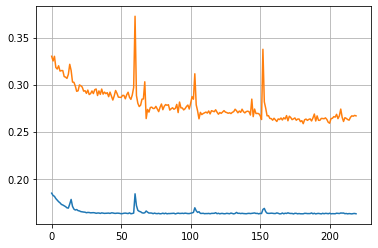

In [24]:
plt.plot(h.history['loss'][30:])
plt.plot(h.history['val_loss'][30:])
plt.grid()

### Validate prediction

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


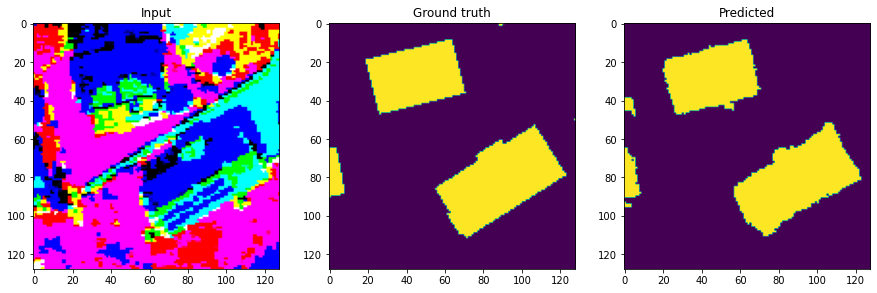

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


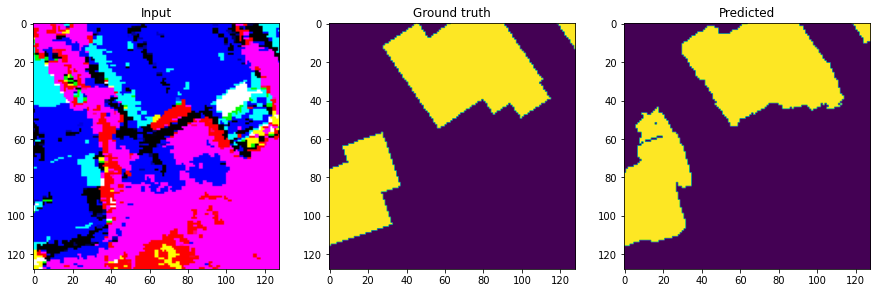

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


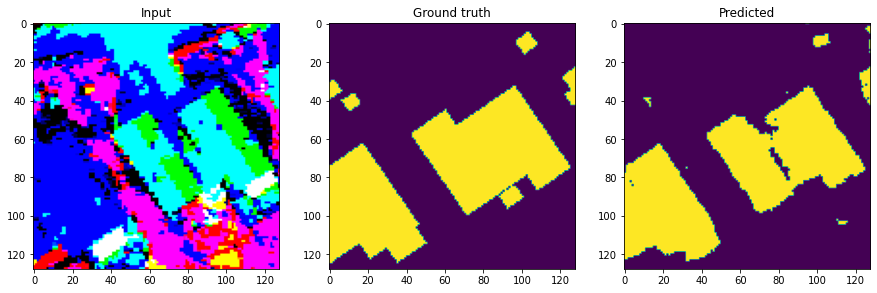

In [25]:
for _ in range(3):
  x = np.random.randint(X_val.shape[0])
  fig, (ax1, ax2, ax3) = plt.subplots(nrows=1,ncols=3, figsize = (15,15))
  #ax1.imshow(np.dstack((X_val[x:x+1][0][:,:,76],
  #                      X_val[x:x+1][0][:,:,46],
  #                      X_val[x:x+1][0][:,:,21])))
  ax1.imshow(X_val[x:x+1][0][:,:,0:3])
  ax1.set_title("Input")
  ax2.imshow(y_val[x:x+1][0].argmax(axis=2))
  ax2.set_title("Ground truth")
  pred = model.predict(X_val[x:x+1])[0].argmax(axis=2)
  ax3.imshow(pred)
  ax3.set_title("Predicted")
  plt.show()

## Test on unseen data

In [26]:
pred = model.predict(X_test)

In [27]:
from sklearn.metrics import balanced_accuracy_score

In [28]:
print("Metrics on whole pred and useen")
print(f"f1 score: {f1_score(y_test.argmax(axis=3).flatten(), pred.argmax(axis=3).flatten())}")
print(f"acc score: {accuracy_score(y_test.argmax(axis=3).flatten(), pred.argmax(axis=3).flatten())}")

Metrics on whole pred and useen
f1 score: 0.6896813918337241
acc score: 0.9384234619140625


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


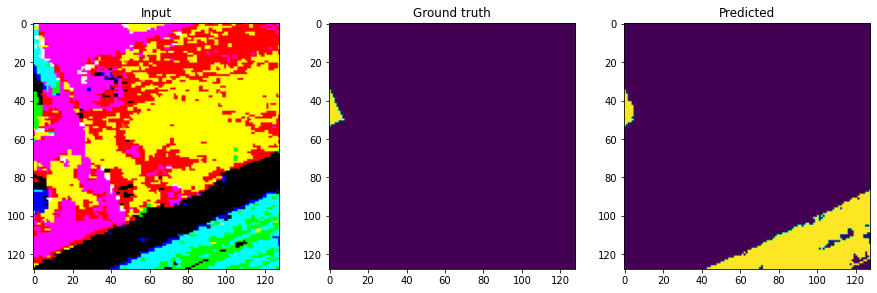

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Acc score: 0.90216064453125
f1 score: 0.07180081065431383


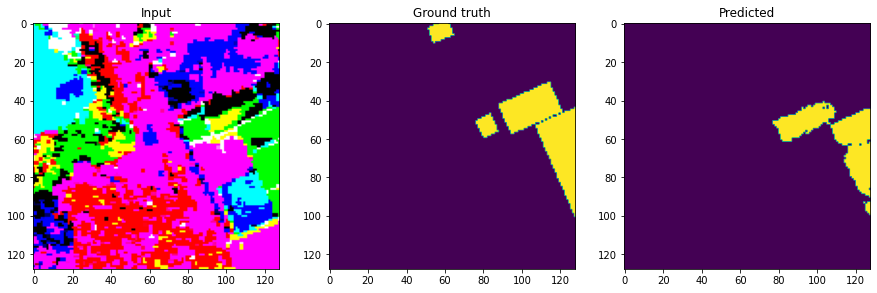

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Acc score: 0.96551513671875
f1 score: 0.7485536270582999


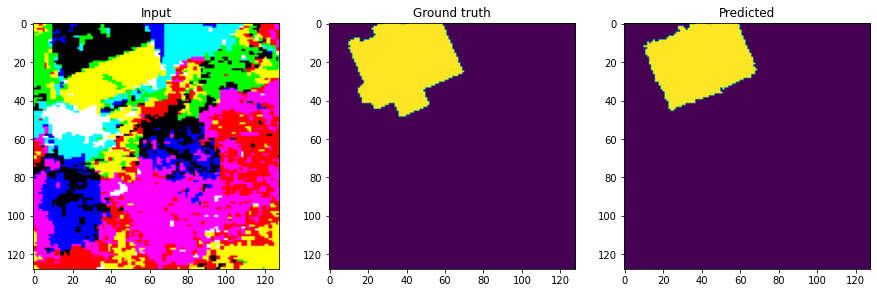

Acc score: 0.983642578125
f1 score: 0.9281115879828328


In [29]:
for _ in range(3):
  x = np.random.randint(pred.shape[0])
  fig, (ax1, ax2, ax3) = plt.subplots(nrows=1,ncols=3, figsize = (15,15))
  #ax1.imshow(np.dstack((X_test[x:x+1][0][:,:,76],
  #                      X_test[x:x+1][0][:,:,46],
  #                      X_test[x:x+1][0][:,:,21])))
  ax1.imshow(X_test[x:x+1][0][:,:,0:3])
  ax1.set_title("Input")
  ax2.imshow(y_test[x:x+1][0].argmax(axis=2))
  ax2.set_title("Ground truth")
  ax3.imshow(pred[x:x+1][0].argmax(axis=2))
  ax3.set_title("Predicted")
  plt.show()

  # Metrics  w threshold:
  pred[x:x+1,:,:,0][pred[x:x+1,:,:,0] > .5] = 1
  pred[x:x+1,:,:,0][pred[x:x+1,:,:,0] <= .5] = 0
  pred[x:x+1,:,:,1][pred[x:x+1,:,:,1] > .5] = 1
  pred[x:x+1,:,:,1][pred[x:x+1,:,:,1] <= .5] = 0

  print(f"Acc score: {accuracy_score(y_test[x:x+1][0].argmax(axis=2).flatten(),\
                                     pred[x:x+1][0].argmax(axis=2).flatten())}")
  print(f"f1 score: {f1_score(y_test[x:x+1][0].argmax(axis=2).flatten(),\
                                     pred[x:x+1][0].argmax(axis=2).flatten())}")
  
  

In [ ]:
import seaborn as sns
sns.displot(pred[:,:,:,0])

ValueError: ignored

In [ ]:
!git pull

remote: Enumerating objects: 7, done.
remote: Counting objects: 100% (7/7), done.
remote: Compressing objects: 100% (4/4), done.
remote: Total 4 (delta 2), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (4/4), done.
From https://github.com/stianteien/M_DV_V2022
   032c1eb..e07fd6c  master     -> origin/master
Updating 032c1eb..e07fd6c
Fast-forward
 roofs_w_unet/roof_u-net.ipynb | 844 ++++++++++++++++++++++++++----------------
 1 file changed, 526 insertions(+), 318 deletions(-)
